In [2]:
# Useful functions to use:
# skimage.draw.line_nd
# numpy.convolve
# jpg i dicom
#TODO przetwarzanie obrazu stożkowo, 90-270 na 4    50%
#TODO 90-720 x, miary zgodności y
#TODO filtrowanie

In [2]:
import numpy as np
import skimage as ski
import matplotlib.pyplot as plt

In [3]:
def loadImage(filename):
    image = ski.io.imread(filename)
    image = ski.color.rgb2gray(image)
    image /= np.max(image)
    return image

def saveImage(image, filename):
    data = (image * 255).astype(np.uint8)
    ski.io.imsave(filename, data)

def showImage(image):
    plt.imshow(image, cmap='gray')
    plt.show()

In [4]:
import pydicom

# Use this file as a wireframe while constructing a new DICOM file
REFERENCE_DICOM = 'dicom/Kolo.dcm'
def loadDicom(filename):
    ds = pydicom.dcmread(filename)
    imageData = ds.pixel_array
    image = imageData / np.max(imageData)

    patName = ds.PatientName
    displayName = patName.given_name + " " + patName.family_name
    comment = ds.ImageComments
    acquisitionDate = ds.get('AcquisitionDate', None)

    metadata = (displayName, comment, acquisitionDate)
    return image, metadata

def saveDicom(filename, image, metadata):
    imageData = (image * 255).astype(np.uint8)

    ds = pydicom.dcmread(REFERENCE_DICOM)
    ds.PixelData = imageData.tobytes()
    ds.Rows, ds.Columns = imageData.shape

    patName = metadata[0].split(' ', maxsplit=1)
    ds.PatientName = patName[1] + '^' + patName[0]
    ds.ImageComments = metadata[1]
    ds.AcquisitionDate = metadata[2]
    ds.save_as(filename, write_like_original=False)


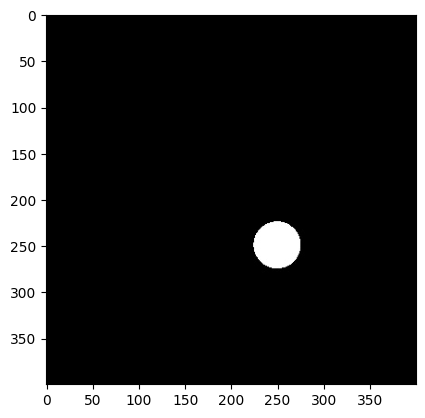

In [18]:
image = loadImage('images/Kropka.jpg')
showImage(image)

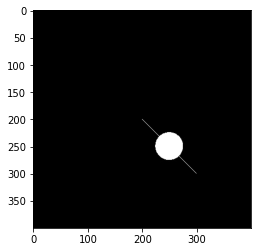

In [7]:
l = ski.draw.line_nd((200, 200), (300, 300))
image[l] = 1
showImage(image)
saveImage(image, 'Kropka.png')

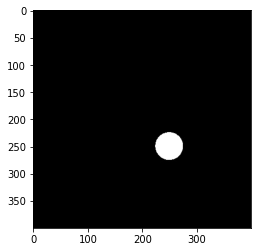

('John Doe', 'what a lovely image we have here...', None)


In [8]:
dicomImage, metadata = loadDicom('dicom/Kropka.dcm')
showImage(dicomImage)
print(metadata)

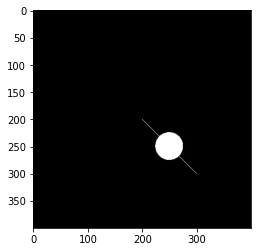

In [9]:
l = ski.draw.line_nd((200, 200), (300, 300))
dicomImage[l] = 1
showImage(dicomImage)
saveDicom('Kropka.dcm', dicomImage, (metadata[0], 'Kropka', '20230304'))

# Image processing
### Radon transform

In [26]:
# Performs a Radon transform on an image
# image: 2D array (floats in range [0, 1])
# detectors: number of detectors (equally spaced on an arc)
# scans: number of samples to take (emitter positions equally spaced around the circle)
# detectingAngle: angle of the arc (in degrees) with detectors
def radonTransform(image, detectors = 180, scans = 180, detectingAngle = 180):
    center = np.array(image.shape) // 2     # Center of the emitter-detector system
    radius = np.sqrt(2) * max(center)       # Radius of the round frame (half-diagonal of the image)
    radonImage = np.zeros((scans, detectors), dtype=image.dtype)
    phi = np.deg2rad(detectingAngle)        # Span of the detectors arc

    # Where to place the emitter in subsequent scans
    scanAngles = np.linspace(0, 2 * np.pi, scans, endpoint=False)
    detectorAngleGap = phi / (detectors - 1)
    for i, angle in enumerate(scanAngles):
        E = np.array([np.cos(angle), np.sin(angle)]) * radius + center

        for j in range(detectors):
            # Where to place the j-th detector
            detectorAngle = angle + np.pi - phi / 2 + j * detectorAngleGap
            D = np.array([np.cos(detectorAngle), np.sin(detectorAngle)]) * radius + center

            # Make a line between the emitter and the detector
            # And ensure it is in bounds of the image
            y, x = ski.draw.line_nd(E, D)
            inBounds = (0 <= x) & (x < image.shape[1]) & (0 <= y) & (y < image.shape[0])
            line = (y[inBounds], x[inBounds])
            # Average the values of the image along the line
            radonImage[i, j] = np.average(image[line])
    return radonImage

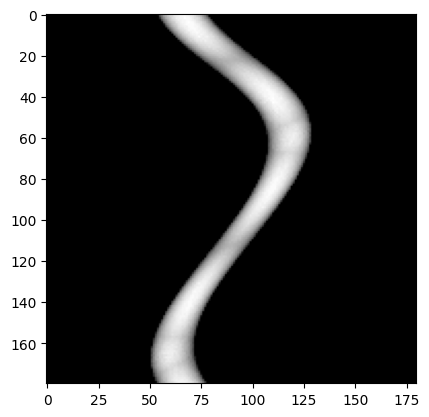

In [30]:
image = loadImage('images/Kropka.jpg')
radonImage = radonTransform(image)
showImage(radonImage)

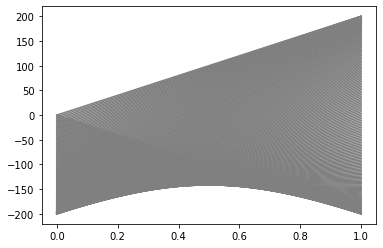

In [23]:
import math

#coords = np.array(image.shape[0], image.shape[1]) #1-400 array
#x, y = image.shape[0], image.shape[1]

n = 90 							# not sure
r = 200 						# not sure
plot = [[],[]]
for alpha in range(90, 271):
	radiansAlpha = math.radians(alpha)
	xE = r * math.cos(radiansAlpha)
	yE = r * math.sin(radiansAlpha)
	for i in range(n):
		fi = 90/n  				# not sure
		xD = r * math.cos(radiansAlpha + math.pi + fi/2 + i*fi/(n-1))
		yD = r * math.sin(radiansAlpha + math.pi + fi/2 + i*fi/(n-1))
	plot[0].append(xE)
	plot[1].append(yE)
plt.plot(plot, color="gray")
plt.show()
#print(plot)
#showImage(plot)
